# Apply Photometric Classification To Fit Results

This notebook applies the photometric classification method from González-Gaitán et al. 2014 to SDSS, DES, and CSP light-curve fits. Results are then used to analyze the properties of peculiar supernovae.

In [1]:
import sys

import numpy as np
import pandas as pd
from astropy.table import Table
from bokeh.plotting import figure, output_notebook, show
from matplotlib import pyplot as plt
from scipy import optimize
from sklearn.utils import resample
from sndata.csp import dr1
from sndata.sdss import sako18

sys.path.insert(0, '..')
from phot_class import fom

output_notebook()
dr1.download_module_data()


Loading BokehJS ...

## Load Data

We begin by reading in spectroscopic classificaions for supernovae observed by CSP DR1. We join these classifications with our own classification parameters and perform some book-keeping.

In [2]:
# Read in published CSP DR1 classifications
dr1_table_1 = dr1.load_table(1)['SN', 'Type']
csp_spec_class = pd.DataFrame({
    'obj_id': dr1_table_1['SN'],
    'spec_class': dr1_table_1['Type']
})
csp_spec_class.set_index('obj_id', inplace=True)
csp_spec_class.spec_class = csp_spec_class.spec_class.str.title()

# Read in pipeline results and update with the spectroscopic classifications
csp_data = Table.read('../results/csp_dr3_simple_fit_class.ecsv')
csp_data = csp_data.to_pandas(index='obj_id')
csp_data['survey'] = 'CSP'
csp_data['spec_class'] = 'Unknown'
csp_data.update(csp_spec_class)


In [3]:
# We assign a "Normal" classification to DES sn3yr targets 
# since it is a cosmology sample

des_data = Table.read('../results/des_sn3yr_simple_fit_class.ecsv')
des_data = des_data.to_pandas(index='obj_id')
des_data['survey'] = 'DES'
des_data['spec_class'] = 'Normal'


In [15]:
t = Table.read('../results/sdss_sako18_simple_fit_fits.ecsv')
from phot_class.classification import classify_targets
sdss_data = classify_targets(t).to_pandas(index='obj_id')

sdss_master = sako18.load_table('master')['CID', 'Classification']
sdss_spec_class = pd.DataFrame({
    'obj_id': sdss_master['CID'],
    'spec_class': sdss_master['Classification']
})
sdss_spec_class.set_index('obj_id', inplace=True)

# sdss_data = Table.read('../results/sdss_sako18_simple_fit_class.ecsv')
sdss_data['survey'] = 'SDSS'
sdss_data['spec_class'] = 'Unknown'
sdss_data.update(sdss_spec_class)



/anaconda3/envs/phot_class/lib/python3.7/site-packages/ipykernel_launcher.py:3: TableReplaceWarning: converted column 'pre_max' from integer to float
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/envs/phot_class/lib/python3.7/site-packages/ipykernel_launcher.py:3: TableReplaceWarning: converted column 'post_max' from integer to float
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
classifications = pd.concat([csp_data, des_data, sdss_data], sort='True')
classifications.fillna('Unknown')
classifications.head()


,spec_class,survey,x,y
obj_id,,,,
2004dt,Normal,CSP,-318.197389,-388.676952
2004ef,Normal,CSP,-328.198987,-556.395698
2004eo,Normal,CSP,-687.351787,-1852.537250
2004ey,Normal,CSP,-1142.236729,-2014.155333
2004gc,Normal,CSP,-86.161695,-298.987895


Using this table we create a static and an interactive version of our classification results.

In [17]:
def create_static_figure(class_data):
    """Create a static plot chi-squared difference
    
    The input DataFrame is expected to have columns x, y, 
    survey, and spec_class.

    Args:
        class_data (DataFrame): The data to plot
        
    Returns:
         A matplotlib figure
         A matplotlib axis
    """

    markers = {'CSP': 'o', 'DES': 'v', 'SDSS': 's'}

    fig, axis = plt.subplots(1, 1, figsize=(10, 10))
    for i, release in enumerate(set(class_data['survey'])):
        release_data = class_data[class_data['survey'] == release]

        for j, sn_type in enumerate(set(class_data['spec_class'])):
            plot_data = release_data[release_data['spec_class'] == sn_type]
            axis.scatter(
                plot_data['x'],
                plot_data['y'],
                label=sn_type if i == 0 else "",
                color=f'C{j}',
                marker=markers[release],
                s=20
            )

    # axis.axhline(0, linestyle=':', color='black', alpha=.5)
    # axis.axvline(0, linestyle=':', color='black', alpha=.5)
    axis.set_xlabel(r'$\chi^2_{blue}(Ia) - \chi^2_{blue}(91bg)$', fontsize=14)
    axis.set_ylabel(r'$\chi^2_{red}(Ia) - \chi^2_{red}(91bg)$', fontsize=14)

    axis.legend(bbox_to_anchor=(1, 1))
    return fig, axis


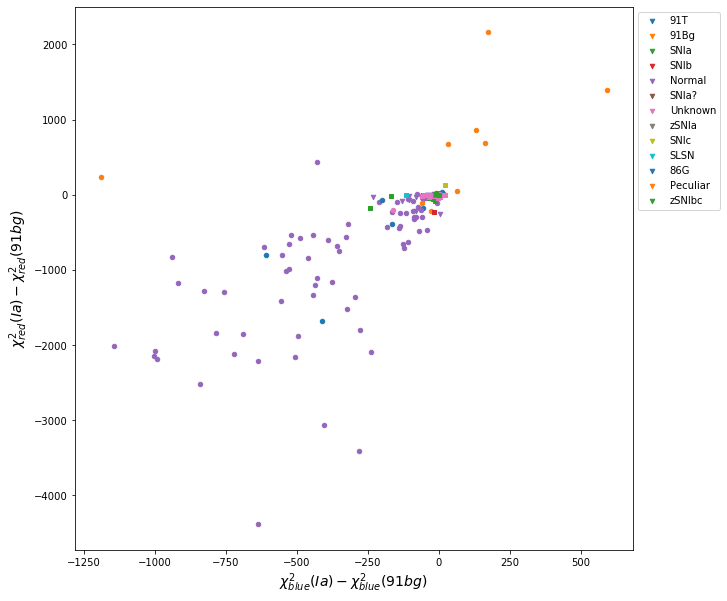

In [18]:
static_fig, static_axis = create_static_figure(classifications)
plt.show()


In [19]:
def create_interactive_figure(class_data):
    """Create an interactive plot chi-squared difference
    
    The input DataFrame is expected to have columns x, y, 
    survey, and spec_class.

    Args:
        class_data (DataFrame): The data to plot
        
    Returns:
         A bokeh figure object
    """

    hover_tooltips = [
        ("obj_id", "@obj_id"),
        ("(x, y)", "(@x, @y)"),
        ("spec_class", "@spec_class"),
        ("survey", "@survey")
    ]

    fig = figure(
        plot_width=600,
        plot_height=600,
        x_axis_label='Blue chisq (Ia - 91bg)',
        y_axis_label='Red chisq (Ia - 91bg)',
        tooltips=hover_tooltips
    )

    # We use the default matplotlib color style
    colors = ['#1f77b4',
              '#ff7f0e',
              '#2ca02c',
              '#d62728',
              '#9467bd',
              '#8c564b',
              '#e377c2',
              '#7f7f7f',
              '#bcbd22',
              '#17becf']

    markers = {'CSP': 'circle', 'DES': 'inverted_triangle', 'SDSS': 'square'}
    for release in set(class_data['survey']):
        plot_func = getattr(fig, markers[release])
        release_data = class_data[class_data['survey'] == release]

        for sn_type, color in zip(set(class_data['spec_class']), colors):
            source = release_data[release_data['spec_class'] == sn_type]
            plot_func('x', 'y', source=source, legend=sn_type, color=color)

    fig.legend.location = "bottom_right"
    fig.legend.click_policy = "hide"

    return fig


In [21]:
interactive_fig = create_interactive_figure(classifications)
show(interactive_fig)


# Optimize FOM

We use a figure of merit (FOM) value as an optimization parameter for training our classification. The FOM is defined as:

$$FOM = \frac{N_{true}}{N_{tot}} * \frac{N_{true}}{N_{true} + N_{false}}$$

where $N_{true}$ is the number of objects correctly classified as a given type (e.g. 91bg-like objects), $N_{tot}$ is the total number of that type, and $N_{false}$ is the number of incorrectly classified objects. 


In [10]:
def subplot_fom_boundary(fom_type, axis, *args, **kwargs):
    """Plot the boundaries from an FOM calculation
    
    Args:
        fom_type (str): The type of FOM calculation that was used 
        axis    (Axis): The matplotlib axis to plot on 
        *args  (float): The boundaries of the FOM calculation  
        **kwargs: Plotting options 
    """
    
    xlim = axis.get_xlim()
    ylim = axis.get_ylim()
    if fom_type == 'rectangular':
        axis.axhline(args[0], **kwargs)
        if 'label' in kwargs:
            kwargs.pop('label')

        axis.axvline(args[1], **kwargs)
        
    elif fom_type == 'horizontal':
        axis.axvline(args[0], **kwargs)

    elif fom_type == 'vertical':
        axis.axhline(args[0], **kwargs)

    elif fom_type == 'linear':
        x = np.array([-1e4, 1e4])
        axis.plot(x, args[0] * x + args[1], **kwargs)

    elif fom_type == 'diagonal':
        x = np.array([-1e4, 1e4])
        axis.plot(x, - x + args[0], **kwargs)

    else:
        raise ValueError(f'Unknown FOM type {fom_type}')

    axis.set_xlim(xlim)
    axis.set_ylim(ylim)
    axis.legend()


../phot_class/fom.py:93: RuntimeWarning: invalid value encountered in long_scalars
  return (ntrue / ntotal) * (ntrue / (ntrue + nfalse))


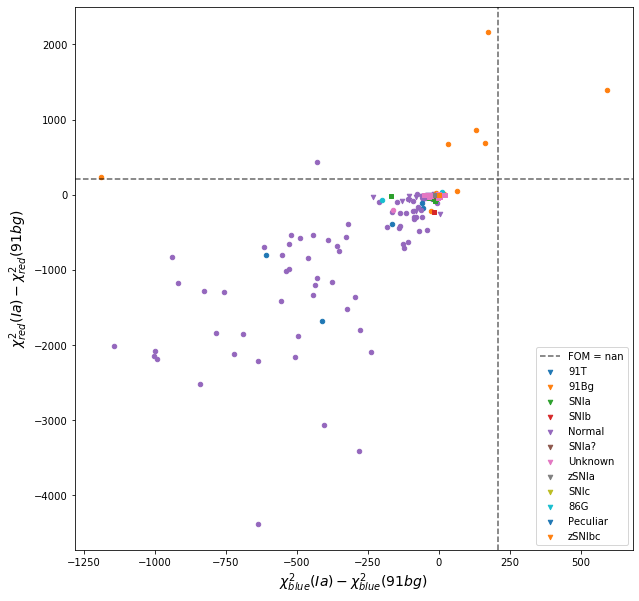

In [11]:
static_fig, static_axis = create_static_figure(classifications)

rectangular_lam = lambda args: 1 - fom.rectangular(truth=classifications['spec_class'],
    x=classifications['x'], 
    y=classifications['y'], 
    x_cutoff=args[0], 
    y_cutoff=args[1], 
    check_type='91bg')

rectangular_min = optimize.minimize(rectangular_lam, np.array([0, 0]), method='Powell')
x_cutoff, y_cutoff = rectangular_min['x']
rectangular_fom = 1 - rectangular_min['fun']

subplot_fom_boundary(
    'rectangular', 
    static_axis, 
    x_cutoff, 
    y_cutoff,
    linestyle='--', 
    color='black', 
    alpha=.6, 
    label=f'FOM = {rectangular_fom:.3}')

plt.show()

KeyboardInterrupt: 

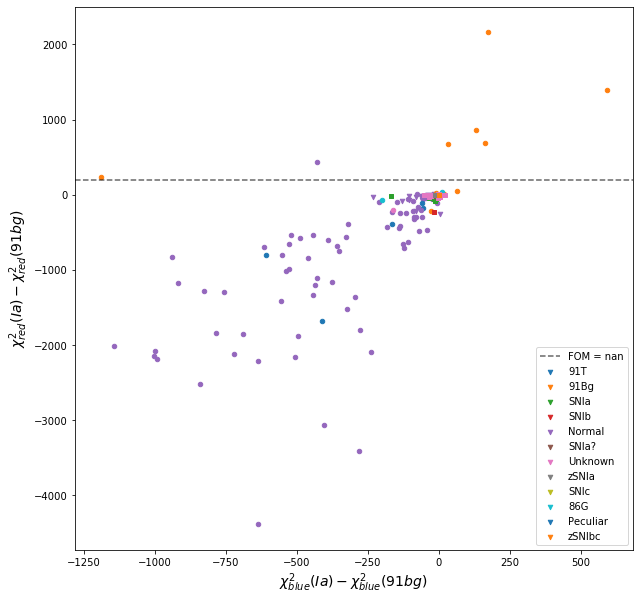

In [12]:
static_fig, static_axis = create_static_figure(classifications)

vertical_lam = lambda args: 1 - fom.vertical(truth=classifications['spec_class'],
    y=classifications['y'], 
    y_cutoff=args[0], 
    check_type='91bg')

vertical_min = optimize.minimize(vertical_lam, np.array([0]), method='Powell')
vertical_cutoff = vertical_min['x']
vertical_fom = 1 - vertical_min['fun']

subplot_fom_boundary(
    'vertical', 
    static_axis, 
    vertical_cutoff, 
    linestyle='--',
    color='black',
    alpha=.6, 
    label=f'FOM = {vertical_fom:.3}')

horizontal_lam = lambda args: 1 - fom.horizontal(truth=classifications['spec_class'],
    x=classifications['x'], 
    x_cutoff=args[0], 
    check_type='91bg')

horizontal_min = optimize.minimize(horizontal_lam, np.array([0]), method='Powell')
horizontal_cutoff = horizontal_min['x']
horizontal_fom = 1 - horizontal_min['fun']

subplot_fom_boundary(
    'horizontal', 
    static_axis, 
    horizontal_cutoff, 
    linestyle=':',
    color='black',
    alpha=.6, 
    label=f'FOM = {horizontal_fom:.3}')


In [ ]:
static_fig, static_axis = create_static_figure(classifications)

diagonal_lam = lambda args: 1 - fom.diagonal(truth=classifications['spec_class'],
    x=classifications['x'], 
    y=classifications['y'],
    b=args[0],
    check_type='91bg')

diagonal_min = optimize.minimize(diagonal_lam, np.array([0]), method='Powell')
diagonal_b = diagonal_min['x']
diagonal_fom = 1 - diagonal_min['fun']

subplot_fom_boundary(
    'diagonal', 
    static_axis, 
    diagonal_b, 
    linestyle='--', 
    color='black', 
    alpha=.6,
    label=f'Diagonal FOM ({diagonal_b:.2}) = {diagonal_fom:.3}')

linear_lam = lambda args: 1 - fom.linear(truth=classifications['spec_class'],
    x=classifications['x'], 
    y=classifications['y'],
    m=args[0],
    b=args[1],
    check_type='91bg')

linear_min = optimize.minimize(linear_lam, np.array([-5, 0]), method='Powell')
linear_m, linear_b = linear_min['x']
linear_fom = 1 - linear_min['fun']

subplot_fom_boundary(
    'diagonal', 
    static_axis, 
    linear_m, 
    linear_b, 
    linestyle=':', 
    color='black', 
    alpha=.6,
    label=f'Linear FOM ({linear_m:.2}, {linear_b:.2})= {linear_fom:.4}')


## Bootstrap

Now that we have a figure of merit optimization, we can bootstrap our data to determine our final classification parameters.

In [ ]:
# configure bootstrap
n_iterations = 100
n_size = int(len(classifications) * 0.50)

# run bootstrap
fom_values = []
classification_params = []
for i in range(n_iterations):
    # prepare train and test sets
    sample_data = resample(classifications, n_samples=n_size)
    result = optimize.minimize(rectangular_lam, [0, 0], method='Powell')

    fom_values.append(1 - result.fun)
    classification_params.append(result.x)

classification_params = np.array(classification_params).T


In [ ]:
def calc_confidence_intervals(alpha, stats):
    p = ((1 - alpha) / 2) * 100
    lower = max(0, np.percentile(stats, p))

    p = (alpha + ((1 - alpha) / 2)) * 100
    upper = min(1.0, np.percentile(stats, p))

    return lower, upper


alpha=0.95
confidence = 0.95
average_fom = np.average(fom_values)
fom_interval = calc_confidence_intervals(confidence, fom_values)

print(f'Average FOM: {average_fom}')
print(f'{alpha * 100:.1f} confidence interval: [{fom_interval[0] * 100:.1f} '
      f', {fom_interval[1] * 100:.1f}]')

average_params = np.average(classification_params, axis=1)
blue_param_interval = calc_confidence_intervals(confidence, classification_params[0])
red_param_interval = calc_confidence_intervals(confidence, classification_params[1])

print(f'Average classification params: {average_params}')
print(f'{alpha * 100} confidence interval for blue '
      f'boundary: [{blue_param_interval[0]:.2f} '
      f', {blue_param_interval[1]:.2f}]')

print(f'{alpha * 100} confidence interval for red '
      f'boundary: [{red_param_interval[0]:.2f} '
      f', {red_param_interval[1]:.2f}]')
